In [1]:
import numpy as np
import tensorflow as tf
from backend.fast_weights_network import Model
import backend as be
from backend.simulation_tools import Simulator
from tasks import memory_tasks as mt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def relu(x):
    return np.maximum(x,0)

def state_to_out(s,w):
    return relu(s).dot(w['W_out'].T) + w['b_out']

In [3]:
mem_gap_length = 20

tag = 'xor_fw7'
weights_path = '../weights/' + tag + '.npz'
trials_path = '../weights/' + tag + '_trials.npz'
    
#task params
input_wait = 20
stim_dur = 10
out_gap = 0
out_dur = 40

var_delay_length = 0
var_in_wait = 0
var_out_gap = 0
second_in_scale = 1.  #Only one input period or two (e.g. mem saccade no distractor vs with distractor)
go_cue = False
task = 'xor'
name = 'xor_fixed'

#model params
n_in = 2 
N_rec = 50 
n_out = 2
#n_steps = 80 
tau = 100.0 #As double
dt = 10.0  #As double
dale_ratio = 0
rec_noise = 0.01
stim_noise = 0.0
batch_size = 128

#regularization
L2_firing_rate = 1.


#train params
learning_rate = .0001 
training_iters = 3000000
display_step = 20

# weights_path = '../weights/' + name + '_' + str(mem_gap_length) + '.npz'
#weights_path = None

params = mt.set_params(epochs=200, sample_size= batch_size, input_wait=input_wait, 
                    stim_dur=stim_dur, mem_gap=mem_gap_length, out_gap = out_gap, out_dur=out_dur, 
                    N_rec=N_rec, n_out = n_out, n_in = n_in, 
                    var_delay_length=var_delay_length, go_cue = go_cue,
                    var_in_wait = var_in_wait, var_out_gap = var_out_gap,
                    rec_noise=rec_noise, stim_noise=stim_noise, 
                    dale_ratio=dale_ratio, dt=dt, tau=tau, task=task,
                    second_in_scale=second_in_scale,
                    L2_firing_rate=L2_firing_rate)

generator = mt.generate_train_trials(params)

In [4]:
#Fast Weight specific params
params['tau_fw'] = 500.       #initial time constant of fast_weights
params['gamma_train'] = False  #trainable gamma (dt/tu_fw)
params['phi_train'] = True    #trainable phi (sensitivity to fws)
params['global_phi'] = False  #Single global or synapse specific plasticity

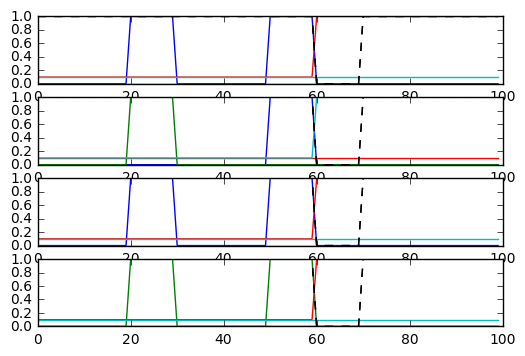

In [15]:
trial = mt.build_train_trials(params)

for ii in range(4):
    plt.subplot(4,1,ii+1)
    plt.plot(trial[0][ii,:,:])
    plt.plot(trial[1][ii,:,:])
    plt.plot(trial[2][ii,:,:],'k--')
plt.show()



In [6]:
model = Model(params)
sess = tf.Session()
t,fw,phi,gamma,s,trial_data = model.train(sess, generator, learning_rate = learning_rate, training_iters = training_iters,
            save_weights_path = weights_path, display_step=display_step,batch_size=batch_size)

sess.close()

np.savez(trials_path, s=s, fw=fw, phi=phi, trial_data=trial_data, gamma=gamma)

Iter 2560, Minibatch Loss= 0.204738
Norm of Phi= 0.0470916
Gamma= [ 0.02185581]
Norm of Grad Wrec= 0.0370426
Iter 5120, Minibatch Loss= 0.197805
Norm of Phi= 0.107849
Gamma= [ 0.02446878]
Norm of Grad Wrec= 0.0641103
Iter 7680, Minibatch Loss= 0.187053
Norm of Phi= 0.185966
Gamma= [ 0.02767665]
Norm of Grad Wrec= 0.106294
Iter 10240, Minibatch Loss= 0.172313
Norm of Phi= 0.282443
Gamma= [ 0.03141819]
Norm of Grad Wrec= 0.155749
Iter 12800, Minibatch Loss= 0.156001
Norm of Phi= 0.389086
Gamma= [ 0.03554581]
Norm of Grad Wrec= 0.107169
Iter 15360, Minibatch Loss= 0.147942
Norm of Phi= 0.442154
Gamma= [ 0.03841319]
Norm of Grad Wrec= 0.0573408
Iter 17920, Minibatch Loss= 0.142224
Norm of Phi= 0.473123
Gamma= [ 0.04058196]
Norm of Grad Wrec= 0.0554823
Iter 20480, Minibatch Loss= 0.137682
Norm of Phi= 0.51367
Gamma= [ 0.0431982]
Norm of Grad Wrec= 0.0471201
Iter 23040, Minibatch Loss= 0.134476
Norm of Phi= 0.549831
Gamma= [ 0.04542838]
Norm of Grad Wrec= 0.0377355
Iter 25600, Minibatch Loss

(100, 128, 50, 50)
(128, 50)


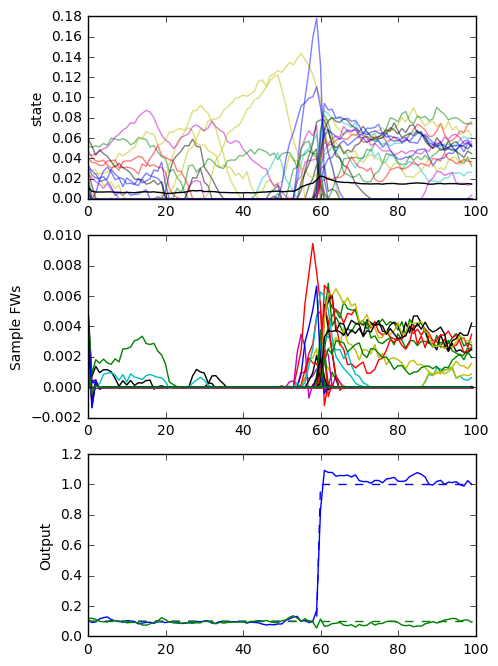

In [20]:
trials = np.load(trials_path)
w = np.load(weights_path)

s = trials['s']
fw = trials['fw']
trial_data = trials['trial_data']
phi = trials['phi']

print np.asarray(fw).shape
# print phi
print s[0].shape



fw_ = np.asarray(fw)
s_ = np.asarray(s)

plt.figure(figsize=(5,8))

plt.subplot(3,1,1)
plt.plot(relu(s_[:,0,:]),alpha=.5)
plt.plot(np.mean(relu(s_[:,0,:]),axis=1),'k')
plt.ylabel('state')

plt.subplot(3,1,2)
idx = np.random.randint(low=0,high=N_rec,size=[100,2])
for ii in range(len(idx)):
    plt.plot(fw_[:,0,idx[ii,0],idx[ii,1]])

plt.ylabel('Sample FWs')

plt.subplot(3,1,3)
o = state_to_out(s_[:,0,:],w)
plt.plot(o[:,0],'b')
plt.plot(o[:,1],'g')
plt.plot(trial_data[1][0,:,0],'b--')
plt.plot(trial_data[1][0,:,1],'g--')
plt.ylabel('Output')

plt.show()

In [8]:
trials.keys()

['trial_data', 's', 'phi', 'gamma', 'fw']

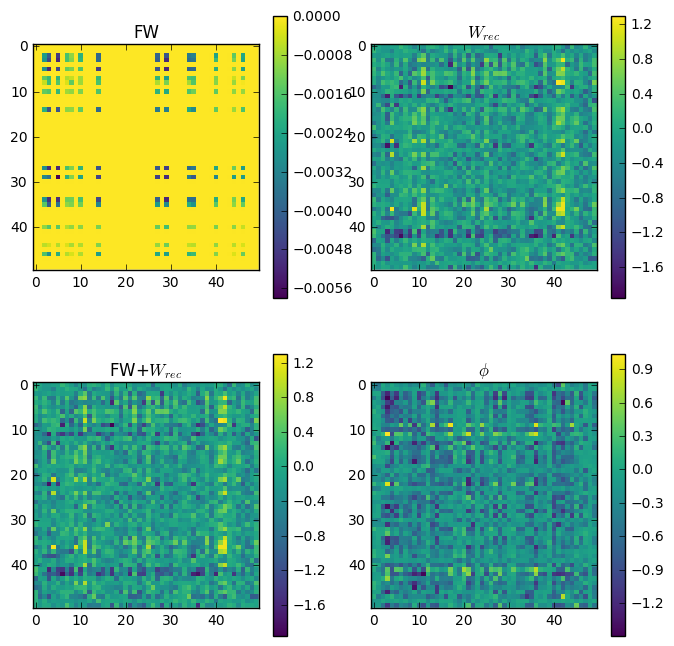

In [9]:


phi_ = phi

max_fw = np.argmax(np.sum(np.sum(np.sum(fw_,axis=3),axis=2),axis=1))

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(fw_[80,0,:,:]*phi_,interpolation='none')
plt.title('FW')
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(w['W_rec'],interpolation='none')
plt.title('$W_{rec}$')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(fw_[80,0,:,:]*phi_+w['W_rec'],interpolation='none')
plt.title('FW+$W_{rec}$')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(phi,interpolation='none')
plt.title('$\phi$')
plt.colorbar()

plt.show()

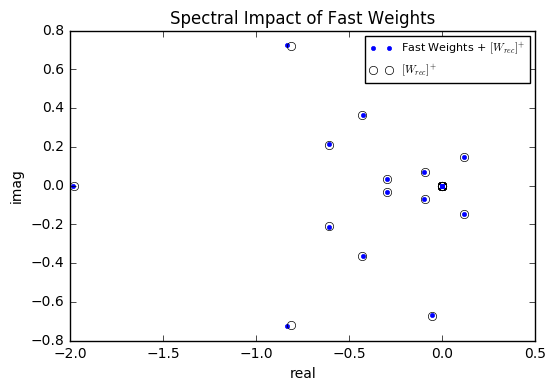

In [18]:
time = 70

part = s_[time,0,:]>0
w_eff = w['W_rec']*part

efw = np.linalg.eig((fw_[time,0,:,:]*part)*phi_+w_eff)[0]
e = np.linalg.eig(w_eff)[0]

plt.plot(efw.real,efw.imag,'.')
plt.plot(e.real,e.imag,'o',color='none')
plt.xlabel('real')
plt.ylabel('imag')
plt.title('Spectral Impact of Fast Weights')
plt.legend(['Fast Weights + $[W_{rec}]^{+}$','$[W_{rec}]^{+}$'],fontsize=8)
plt.show()

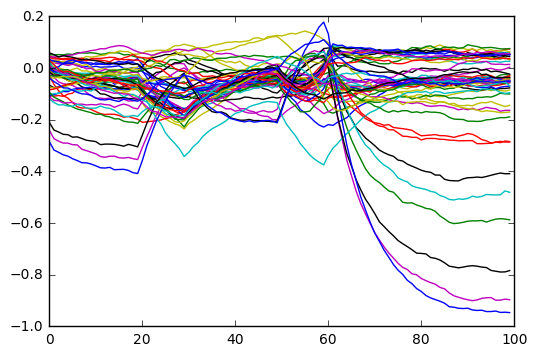

In [11]:
plt.plot(s_[:,0,:])
plt.show()

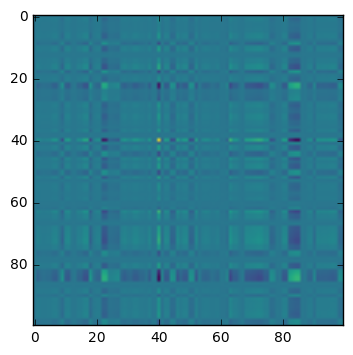

In [12]:
win = w['W_in']

plt.imshow(np.outer(win,win))